In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import re, copy, random, time, datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Flatten, Concatenate, Lambda
from keras.models import Model
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.layers.core import Reshape
import keras.backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive/')

ModuleNotFoundError: No module named 'google.colab'

In [0]:
lines= pd.read_csv('/gdrive/My Drive/nmt/data/train.csv', error_bad_lines=False)
print(lines.shape)
lines = lines[['utterance', 'context']]
lines.sample(10)

(76668, 8)


b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'


,utterance,context
15844,Do you trust them to be home alone? I bet you...,trusting
71410,I am sorry to hear that.,sad
21155,That's okay_comma_ she will forgive you.,embarrassed
5592,I was approached by a man that I did not know ...,apprehensive
74136,That sounds so good,impressed
63697,I'm glad it's over and nothing happened. do yo...,devastated
59415,my pants dropped last week from getting hooked...,annoyed
63183,I have a long drive planned. About 9 hours. ...,anxious
6591,I have to pay out of pocket for school now. It...,devastated
35244,Sometime I envy my coworkers because some of t...,jealous


In [0]:
lines['utterance'] = lines['utterance'].apply(lambda x: x.lower())
lines['utterance'] = lines['utterance'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation)
lines['utterance'] = lines['utterance'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

remove_digits = str.maketrans('', '', digits)
lines['utterance'] = lines['utterance'].apply(lambda x: x.translate(remove_digits))

lines['utterance'] = lines['utterance'].apply(lambda x: x.strip())
lines['utterance'] = lines['utterance'].apply(lambda x: re.sub(" +", " ", x))

lines.drop(lines[lines['utterance'].str.split(' ').map(len) > 40].index, inplace=True)
lines.sample(10)

,utterance,context
73360,i was watching some old tv shows and it really...,nostalgic
51325,ohcomma thats too bad perhaps have the picnic ...,disappointed
73231,cant believe i got that mark,surprised
65101,i also need to reduce my pride i am too pridef...,confident
15163,i hope she is okay also,apprehensive
67843,wow thats a good deal i wish i knew how to fin...,jealous
38621,i took my kids candy from halloween this last ...,guilty
16389,speaking ofcomma i start a new job tomorrow an...,apprehensive
55319,i dont know if that is a good thing or a bad t...,disgusted
63430,im doing awful in math class we had an assignm...,ashamed


In [0]:
def noise(sent):

	sent = sent.split(' ')
	final = []
	for word in sent:
		if random.random() > 0.1:
			final.append(word)

	sent = copy.deepcopy(final)
	final = []
	k = 3
	L = len(sent)
	i = 0
	temp = []
	while i < L:
		if i+k < L:
			temp = sent[i:i+k]
			i += k
		else:
			temp = sent[i:]
			i = L
		random.shuffle(temp)
		final += temp
		temp = []

	return ' '.join(final)

In [0]:
noised_data = []
lines.rename(columns={'utterance':'original'}, inplace=True)
for sent in lines.original:
  noised_data.append(noise(sent))

lines['noised'] = noised_data
# lines['original'] = lines['original'].apply(lambda x : x + ' _END')

vocabulary = set()
for eng in lines.original:
    for word in eng.split():
        if word not in vocabulary:
            vocabulary.add(word)

for sent in lines.noised:
    for word in sent.split():
        if word not in vocabulary:
            vocabulary.add(word)

vocabulary.add('_END')
lines['context'] = lines['context'].apply(lambda x : x.strip())
labels_set = set()
for lab in lines.context:
	if lab not in labels_set:
		labels_set.add(lab)

lines.sample(10)

,original,context,noised
66570,thats funny and unfortunate at the same time i...,embarrassed,funny thats and at the unfortunate time i same...
55244,indeed it is i couldnt hide my excitement in t...,excited,it i indeed my couldnt hide excitement office ...
72183,what a good samaritan be careful next time and...,trusting,good what a samaritan be careful next and time...
11721,i think you should call the cab company and tr...,terrified,you think should call cab company try locate a...
76231,you could get a nice dinner with that have fun,excited,could you get nice a dinner with that have fun
40605,im sorry to hear that,embarrassed,to sorry hear that
22613,wellcomma you should know that your feelings a...,sad,you should know feelings are your thing a norm...
40114,i looked at the other students paper i was so ...,ashamed,looked i at other the students so i paper ashamed
44140,someone should definitely report him,furious,should report someone him
53943,i went to a haunted housecomma it had so many ...,terrified,to went i housecomma haunted a had it many ghosts


In [0]:
print(labels_set, len(labels_set))
# value = 0
# max_length_src = -1
# for l in lines.noised:
# 	if len(l.split(' ')) > 40:
# 		value+=1
# 	max_length_src = max(max_length_src,len(l.split(' ')))

# max_length_tar = -1
# for l in lines.original:
# 	if len(l.split(' ')) > 40:
# 		value+=1
# 	max_length_tar = max(max_length_tar, len(l.split(' ')))
max_length_src = 40
max_length_tar = 40
# max_length_src, max_length_tar, value

{'excited', 'prepared', 'devastated', 'ashamed', 'disgusted', 'trusting', 'terrified', 'content', 'afraid', 'sentimental', 'confident', 'annoyed', 'angry', 'faithful', 'impressed', 'sad', 'surprised', 'anticipating', 'anxious', 'joyful', 'guilty', 'nostalgic', 'furious', 'lonely', 'hopeful', 'disappointed', 'jealous', 'embarrassed', 'apprehensive', 'proud', 'grateful', 'caring'} 32


In [0]:
input_words = sorted(list(vocabulary))
num_encoder_tokens = len(vocabulary)
num_decoder_tokens = len(vocabulary) + 1
num_encoder_tokens, num_decoder_tokens

(21770, 21771)

In [0]:
token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
reverse_index = dict((i, word) for word, i in token_index.items())

lines = shuffle(lines)
lines.head(10)
len(token_index)

21770

In [0]:
labels_set = list(labels_set)
vocab_labels = dict()
for i, lab in enumerate(labels_set):
  vocab_labels[lab] = i
max_lab_len = len(labels_set)

In [0]:
X, y = list(zip(lines.noised, lines.context)), lines.original
X_temp, X_test_temp, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train = []
X_labs = []
for a,b in X_temp:
    if b not in vocab_labels:
        print("NOO")
    X_train.append(a)
    X_labs.append(b)
X_train = np.array(X_train)
X_labs = np.array(X_labs)

X_test = []
X_labs_test = []

for a,b in X_test_temp:
    if b not in vocab_labels:
        print("NOO")
    X_test.append(a)
    X_labs_test.append(b)
X_test = np.array(X_test)
X_labs_test = np.array(X_labs_test)


def generate_batch(X = X_train, X_l = X_labs, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_label_data = np.zeros((batch_size, 1),dtype='float32')
            encoder_label_data2 = np.zeros((batch_size, 1),dtype='float32')
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar+1, num_decoder_tokens),dtype='float32')
            decoder_target_data2 = np.zeros((batch_size, max_length_tar+1, num_decoder_tokens),dtype='float32')
            
            for i, (input_text, lab, target_text) in enumerate(zip(X[j:j+batch_size], X_l[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = token_index[word]
                encoder_label_data[i, 0] = vocab_labels[lab]
                encoder_label_data2[i, 0] = random.randint(0, len(vocab_labels))
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = token_index[word]
                    if t>=0:
                        decoder_target_data[i, t, token_index[word]] = 1
            for i in range(batch_size):
                for j in range(max_length_src):
                    decoder_target_data2[i, j] = encoder_input_data[i, j]
            decoder_target_data[i, max_length_tar, token_index['_END']] = 1
            decoder_target_data2[i, max_length_tar, token_index['_END']] = 1
            yield([encoder_input_data, encoder_label_data2, encoder_label_data, decoder_input_data], [decoder_target_data, decoder_target_data2])

In [0]:
def get_data(X=X_train, y=y_train, batch_size=128):
  random_list = random.sample(range(0,len(X)), batch_size)
  print(random_list)
  encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
  decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
  decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
  print("Yes")
  for i, j in enumerate(random_list):
      print('Yes')
      input_text = X[j]
      print('Yes')
      target_text = y[j]
      print(input_text, target_text, j)
      for t, word in enumerate(input_text.split()):
          encoder_input_data[i, t] = token_index[word]
      for t, word in enumerate(target_text.split()):
          if t<len(target_text.split())-1:
              decoder_input_data[i, t] = token_index[word]
          if t>0:
              decoder_target_data[i, t - 1, token_index[word]] = 1
              
  return encoder_input_data, decoder_input_data, decoder_target_data, random_list

In [0]:
batch_size = 32
epochs = 10
latent_dim = 128
model_path = '/gdrive/My Drive/nmt/nmt_weights_full.h5'

encoder_inputs = Input(shape=(max_length_src,))
Embeddings = Embedding(num_encoder_tokens, latent_dim, trainable=True)
enc_emb =  Embeddings(encoder_inputs)
print('Embedded Input',enc_emb.shape)

encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]
print('Encoder lstm states',state_h.shape, state_c.shape)

encoder_inputs_temp = Input(shape=(1,))
label_Embeddings = Embedding(max_lab_len, latent_dim, trainable=True)
enc_emb1 = label_Embeddings(encoder_inputs_temp)
print('label 1 shape',enc_emb1.shape)

decoder_inputs = Input(shape=(max_length_tar,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoded embedding shape',dec_emb.shape)

dec_emb = Concatenate(axis=1)([enc_emb1, dec_emb])

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, de_state_h, de_state_c = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


encoder_inputs_temp2 = Input(shape=(1,))
enc_emb2 = label_Embeddings(encoder_inputs_temp2)
print('label2 size',enc_emb2.shape)


print('Decoder out shape',decoder_outputs.shape)
back_data = Lambda(lambda x: K.argmax(x, axis=2))(decoder_outputs)
back_data = Lambda(lambda x : x[:,:-1])(back_data)
print('Back input shape', back_data.shape)

back_emb =  dec_emb_layer(back_data)
print('Back input embedded shape', back_emb.shape)
back_dec_emb = Concatenate(axis=1)([enc_emb2, back_emb])

back_decoder_outputs, _, _ = decoder_lstm(back_dec_emb, initial_state=[de_state_h, de_state_c])
back_decoder_outputs = decoder_dense(back_decoder_outputs)

print('Back decoded out shape',back_decoder_outputs.shape, decoder_outputs.shape, encoder_inputs.shape)
model = Model([encoder_inputs, encoder_inputs_temp, encoder_inputs_temp2, decoder_inputs], [decoder_outputs, back_decoder_outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True)

training_start_time = time.time()

model.fit_generator(generator = generate_batch(X_train, X_labs, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, X_labs_test, y_test, batch_size = batch_size),
                    validation_steps = len(X_test)//batch_size,
                    callbacks = [early_stopping, ModelCheckpoint(filepath = model_path, save_best_only = True)])

print("Training time finished.\n{} epochs in {}".format(epochs, datetime.timedelta(seconds=time.time()-training_start_time)))

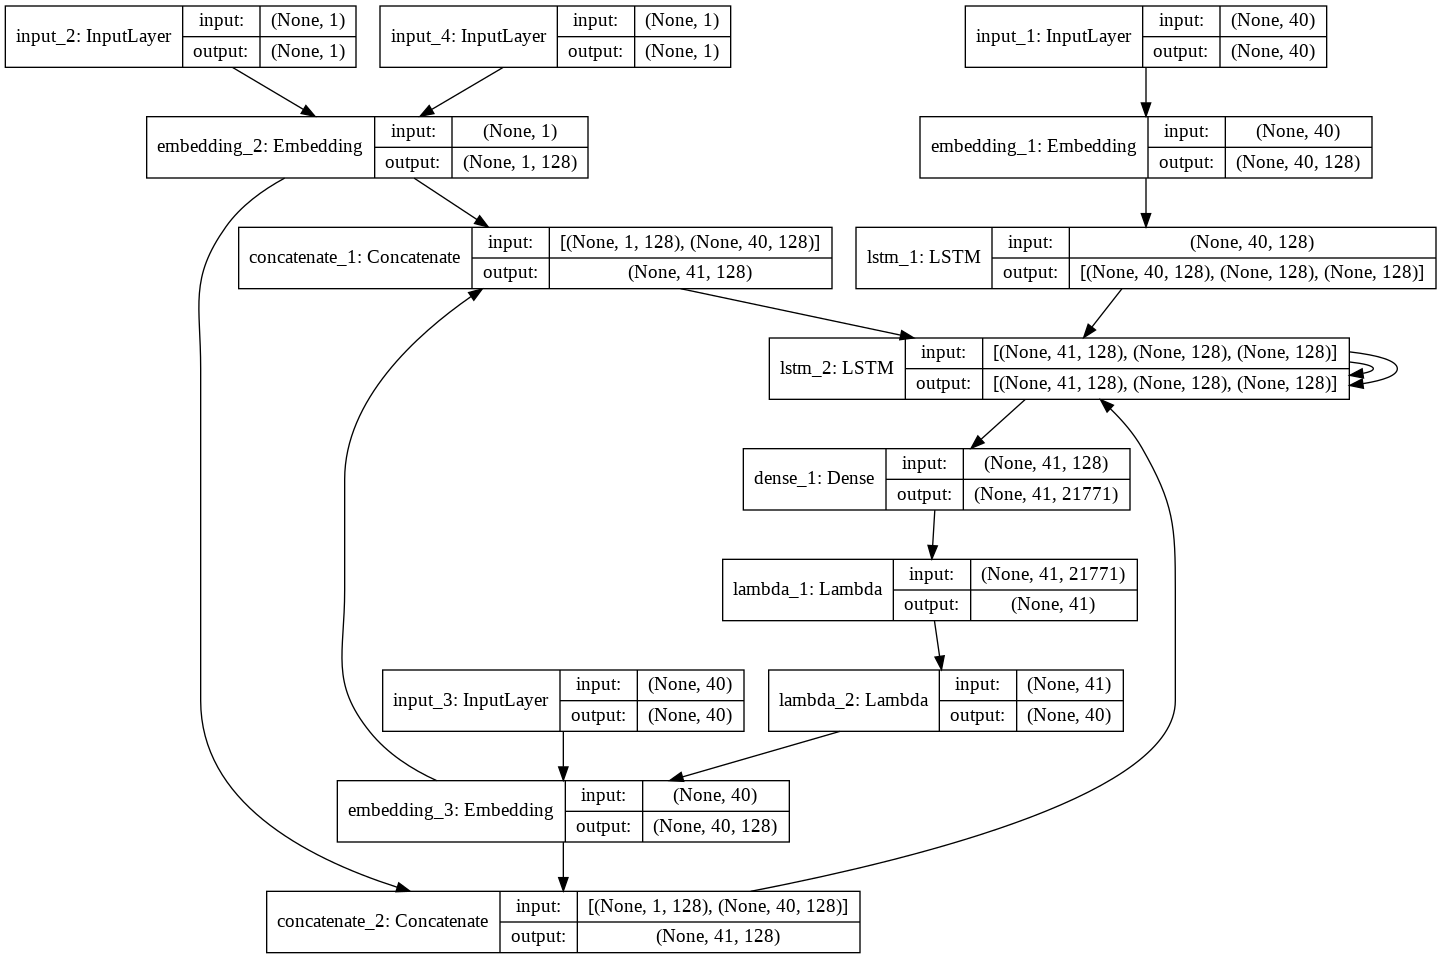

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

encoder_inputs_temp3 = Input(shape=(1,))
enc_emb3 = label_Embeddings(encoder_inputs_temp3)

dec_emb2= dec_emb_layer(decoder_inputs)
inf_emb = Concatenate(axis=1)([enc_emb3, dec_emb2])

decoder_outputs2, state_h2, state_c2 = decoder_lstm(inf_emb, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs, encoder_inputs_temp3] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = token_index['START_']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

In [0]:
print(len(X_train), len(y_train))
input_seq, actual_output, _, indices = get_data(X_train, y_train, 1)
decoded_sentence = decode_sequence(input_seq)

k = indices[0]

print('Input English sentence:', X_train[k])
print('Actual output:', y_train[k][6:-4])
print('Predicted output:', decoded_sentence[:-4])

from nltk.translate import bleu
print(y_train[k][6:-4].split(), decoded_sentence[:-4].split())
print(bleu([y_train[k][6:-4].split()], decoded_sentence[:-4].split()))

68013 68013
[47774]
Yes
Yes
Yes


KeyError: ignored